### Calibration Olympics

In [16]:
import numpy as np
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d

from pygam import LinearGAM, s
import matplotlib.pyplot as plt

In [17]:
class RawCalibrator:
    def fit(self, actuals, preds):
        return self
    def predict(self, preds):
        return preds

class VanillaIsotonicCalibrator:
    def __init__(self):
        self.iso = IsotonicRegression(out_of_bounds='clip')
    def fit(self, actuals, preds):
        self.iso.fit(preds, actuals)
        return self
    def predict(self, preds):
        return self.iso.predict(preds)

class BinnedIsotonicCalibrator:
    def __init__(self, n_bins=100):
        self.n_bins = n_bins
        self.iso_reg = IsotonicRegression(out_of_bounds="clip")
        self.bin_edges = None
        self.binned_pred = None

    def fit(self, actuals, preds):
        self.bin_edges = np.percentile(preds, np.linspace(0, 100, self.n_bins + 1))
        
        bins = np.digitize(preds, self.bin_edges[:-1], right=True)

        self.binned_pred = np.array([np.mean(preds[bins == i]) for i in range(self.n_bins) if np.any(bins == i)])
        binned_actual = np.array([np.mean(actuals[bins == i]) for i in range(self.n_bins) if np.any(bins == i)])

        self.iso_reg.fit(self.binned_pred, binned_actual)
        return self

    def predict(self, preds):
        return self.iso_reg.predict(preds)

class KDEBinnedIsotonicCalibrator:
    def __init__(self, bandwidth=0.1):
        self.bandwidth = bandwidth
        self.iso_reg = None
    def fit(self, actuals, preds):
        kde = gaussian_kde(preds, bw_method=self.bandwidth)
        grid = np.linspace(np.min(preds), np.max(preds), 1000)
        kde_values = kde(grid)
        peaks, _ = find_peaks(kde_values)
        cutpoints = np.sort(grid[peaks]) if len(peaks) > 0 else np.array([])
        bin_edges = np.concatenate(([-np.inf], cutpoints, [np.inf]))
        bins = np.digitize(preds, bin_edges[1:-1], right=True)
        binned_pred, binned_actual = [], []
        for b in np.unique(bins):
            mask = (bins == b)
            if np.sum(mask) > 0:
                binned_pred.append(np.mean(preds[mask]))
                binned_actual.append(np.mean(actuals[mask]))
        self.iso_reg = IsotonicRegression(out_of_bounds='clip')
        self.iso_reg.fit(binned_pred, binned_actual)
        return self
    def predict(self, preds):
        return self.iso_reg.predict(preds)

class GAMCalibrator:
    def __init__(self, n_splines=10):
        self.n_splines = n_splines
        self.gam = None

    def fit(self, actuals, preds):
        X = preds.reshape(-1, 1)
        
        # Five-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        best_gam = None
        best_score = -np.inf

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = actuals[train_idx], actuals[val_idx]
            
            gam = LinearGAM(s(0, n_splines=self.n_splines)).fit(X_train, y_train)
            score = gam.score(X_val, y_val)
            
            if score > best_score:
                best_gam = gam
                best_score = score

        self.gam = best_gam
        return self

    def predict(self, preds):
        return self.gam.predict(preds.reshape(-1, 1))

class LocallySmoothedIsotonicCalibrator:
    def __init__(self, sigma=1):
        """
        Parameters:
          sigma: Standard deviation for Gaussian smoothing.
        """
        self.iso = IsotonicRegression(out_of_bounds='clip')
        self.sigma = sigma
        self.x_sorted = None
        self.fitted_smoothed = None

    def fit(self, actuals, preds):
        """
        Step 1: Fit vanilla isotonic regression.
        Step 2: Apply Gaussian smoothing to relax local monotonicity constraints.
        """
        order = np.argsort(preds)
        x_sorted = preds[order]
        y_sorted = actuals[order]

        # Fit vanilla isotonic regression
        self.iso.fit(x_sorted, y_sorted)
        fitted_values = self.iso.predict(x_sorted)

        # Apply Gaussian smoothing (to allow local monotonicity violations)
        self.fitted_smoothed = gaussian_filter1d(fitted_values, sigma=self.sigma)

        self.x_sorted = x_sorted
        return self

    def predict(self, preds):
        """
        Step 3: Use interpolation to apply smoothed isotonic mapping to new data.
        """
        return np.interp(preds, self.x_sorted, self.fitted_smoothed, 
                         left=self.fitted_smoothed[0], right=self.fitted_smoothed[-1])

class RegularizedIsotonicCalibrator:
    def __init__(self, alphas=None, cv=5):
        """
        Parameters:
          alphas: List of regularization strengths to cross-validate. Default is None (uses a predefined range).
          cv: Number of cross-validation folds.
        """
        self.alphas = alphas if alphas is not None else np.logspace(-2, 1, 10)  # Avoid too small alphas
        self.cv = cv
        self.best_alpha = None
        self.iso_reg = None
        self.x_sorted = None

    def fit(self, actuals, preds):
        """
        Step 1: Perform cross-validation to find the best alpha.
        Step 2: Fit the isotonic regression with the optimal regularization.
        """
        order = np.argsort(preds)
        x_sorted, y_sorted = preds[order], actuals[order]
        
        best_alpha = None
        best_score = float("inf")

        # Cross-validation for best alpha
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        for alpha in self.alphas:
            scores = []
            for train_idx, val_idx in kf.split(x_sorted):
                iso_reg = IsotonicRegression(out_of_bounds="clip")
                iso_reg.fit(x_sorted[train_idx], y_sorted[train_idx])
                
                # Apply smoothing
                smoothed_preds = self._apply_smoothing(iso_reg.predict(x_sorted[val_idx]), alpha)
                scores.append(mean_squared_error(y_sorted[val_idx], smoothed_preds))

            mean_score = np.mean(scores)
            if mean_score < best_score:
                best_score, best_alpha = mean_score, alpha

        self.best_alpha = best_alpha
        self.iso_reg = IsotonicRegression(out_of_bounds="clip")
        self.iso_reg.fit(x_sorted, y_sorted)
        self.x_sorted = x_sorted
        return self

    def _apply_smoothing(self, fitted_values, alpha):
        """
        Applies smoothing (Tikhonov L2 regularization) by convolving with a kernel.
        """
        alpha = max(1, int(alpha))  # Ensure alpha is at least 1
        smoothed = np.convolve(fitted_values, np.ones(alpha) / alpha, mode="same")
        return smoothed

    def predict(self, preds):
        """
        Step 3: Use interpolation to apply the smoothed isotonic mapping to new data.
        """
        fitted_values = self._apply_smoothing(self.iso_reg.predict(self.x_sorted), self.best_alpha)
        return np.interp(preds, self.x_sorted, fitted_values, left=fitted_values[0], right=fitted_values[-1])


class RobustPAVACalibrator:
    def __init__(self, minor_pctile=10):
        """
        Parameters:
          minor_pctile: The percentile used to compute the threshold from the 
                        absolute differences between successive sorted actual values.
                        (Default is 10, meaning the 10th percentile.)
        """
        self.minor_pctile = minor_pctile
        self.x_sorted = None
        self.fitted_sorted = None

    def fit(self, actuals, preds):
        """
        Fit the robust PAVA calibration mapping on training data.
        
        Parameters:
          actuals: array-like, true target values.
          preds: array-like, raw predictions.
          
        Returns:
          self
        """
        # Sort the training predictions (and corresponding actuals)
        order = np.argsort(preds)
        x_sorted = preds[order]
        y_sorted = actuals[order]
        n = len(y_sorted)

        # Compute threshold based on the sorted actual values:
        # This is the 10th percentile of the absolute differences.
        if n > 1:
            diffs = np.diff(y_sorted)  # Difference in actual values
            threshold = np.percentile(np.abs(diffs), self.minor_pctile)
        else:
            threshold = 0

        # Initialize each observation as its own block.
        blocks = []
        for i in range(n):
            blocks.append({
                'indices': [i],
                'sum_y': y_sorted[i],
                'count': 1,
                'avg_y': y_sorted[i]
            })

        # Now run robust PAVA:
        changed = True
        while changed:
            changed = False
            i = 0
            while i < len(blocks) - 1:
                # Check for a violation
                if blocks[i]['avg_y'] > blocks[i+1]['avg_y']:
                    diff_y = blocks[i]['avg_y'] - blocks[i+1]['avg_y']  # Difference in actual values

                    # If the difference in actuals is below the threshold, swap but do not pool
                    if diff_y < threshold:
                        blocks[i]['avg_y'], blocks[i+1]['avg_y'] = blocks[i+1]['avg_y'], blocks[i]['avg_y']
                        changed = True

                    # Otherwise, pool the blocks
                    else:
                        new_indices = blocks[i]['indices'] + blocks[i+1]['indices']
                        new_sum_y = blocks[i]['sum_y'] + blocks[i+1]['sum_y']
                        new_count = blocks[i]['count'] + blocks[i+1]['count']
                        new_avg_y = new_sum_y / new_count

                        blocks[i] = {
                            'indices': new_indices,
                            'sum_y': new_sum_y,
                            'count': new_count,
                            'avg_y': new_avg_y
                        }
                        del blocks[i+1]
                        changed = True
                        if i > 0:
                            i -= 1
                            continue  # Re-check previous pair
                i += 1

        # Now assign the fitted (calibrated) values in the sorted order.
        fitted_sorted = np.empty(n)
        for block in blocks:
            for idx in block['indices']:
                fitted_sorted[idx] = block['avg_y']

        # Store the sorted predictions and the corresponding fitted values.
        self.x_sorted = x_sorted
        self.fitted_sorted = fitted_sorted
        return self

    def predict(self, preds):
        """
        Map new predictions using linear interpolation from the training mapping.
        """
        return np.interp(preds, self.x_sorted, self.fitted_sorted,
                         left=self.fitted_sorted[0], right=self.fitted_sorted[-1])

In [18]:
def compute_calibration_metrics(calibrated_preds, actuals, original_preds, n_bins=20):
    """
    Computes calibration metrics including MSE, MAE, unique values, Spearman correlations,
    and Binned Mean Calibration Error (BMCE).

    Parameters:
    - calibrated_preds: Dictionary of method names to calibrated predictions.
    - actuals: Array of actual values.
    - original_preds: Array of original uncalibrated predictions.
    - n_bins: Number of bins for computing BMCE (default: 20).

    Returns:
    - DataFrame containing calibration metrics for each method.
    """
    results = []
    unique_orig = len(np.unique(original_preds))

    for name, preds in calibrated_preds.items():
        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        unique_calibrated = len(np.unique(preds))
        spearman_actual = spearmanr(preds, actuals)[0]
        spearman_pred = spearmanr(preds, original_preds)[0]

        # Compute Binned Mean Calibration Error (BMCE)
        bin_edges = np.percentile(original_preds, np.linspace(0, 100, n_bins + 1))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        binned_actuals = [np.mean(actuals[(original_preds >= bin_edges[i]) & (original_preds < bin_edges[i+1])]) 
                          for i in range(n_bins)]
        binned_calibrated = [np.mean(preds[(original_preds >= bin_edges[i]) & (original_preds < bin_edges[i+1])]) 
                             for i in range(n_bins)]
        
        bmce = np.mean(np.abs(np.array(binned_actuals) - np.array(binned_calibrated)))  # Mean absolute error between bins

        results.append({
            "Method": name,
            "MSE": mse,
            "MAE": mae,
            "Unique Original": unique_orig,
            "Unique Calibrated": unique_calibrated,
            "Spearman Corr (Actual)": spearman_actual,
            "Spearman Corr (Preds)": spearman_pred,
            "Binned Mean Calibration Error": bmce
        })

    return pd.DataFrame(results)

### Simulate Data

In [19]:
np.random.seed(42)
n_samples = 50000

# Step 1: Generate actual values
actuals = np.zeros(n_samples)

# 7% are ones, with a large skew from 10 to 100,000
positive_mask = np.random.rand(n_samples) < 0.07
actuals[positive_mask] = np.exp(np.random.uniform(np.log(10), np.log(100000), size=positive_mask.sum()))

# Ensure probability of 1s increases with size
prob_ones = stats.norm.cdf((np.log1p(actuals) - np.mean(np.log1p(actuals[positive_mask]))) / np.std(np.log1p(actuals[positive_mask])))
actuals = (np.random.rand(n_samples) < prob_ones).astype(float)

# Step 2: Generate biased predictions
preds = np.zeros(n_samples)

# Non-linear bias: 
# - Negative bias for smaller values
# - Positive bias for larger values
true_values = actuals * np.exp(np.random.uniform(np.log(10), np.log(100000), size=n_samples))

# Apply smooth bias transformation
bias_factor = 0.7 + 0.6 * (true_values / np.max(true_values))  # Bias shifts from 0.7 to 1.3 smoothly
preds = true_values ** 0.7 * bias_factor  # Apply bias transformation

# Add noise to predictions while ensuring positivity
noise_scale = np.std(preds) * 2.0  # Increase noise to reduce correlation
preds += np.abs(np.random.normal(0, noise_scale, n_samples))  # Ensure added noise is non-negative

# Verify correlation
correlation = np.corrcoef(preds, actuals)[0, 1]

# Display results
print(f"Correlation: {correlation:.3f}, Mean Actuals: {np.mean(actuals):.5f}, Mean Predictions: {np.mean(preds):.5f}")

# Keep noise for zero values
preds[~positive_mask] = np.abs(np.random.normal(0, 1, size=(~positive_mask).sum()))

Correlation: 0.321, Mean Actuals: 0.03894, Mean Predictions: 324.56220


### Train/Test Split and Eval.

In [20]:
# Shuffle and split data into train (80%) and test (20%) sets
indices = np.arange(n_samples)
np.random.shuffle(indices)

split_idx = int(0.8 * n_samples)
train_actual, test_actual = actuals[indices[:split_idx]], actuals[indices[split_idx:]]
train_pred, test_pred = preds[indices[:split_idx]], preds[indices[split_idx:]]

# Initialize calibrators including Regularized Isotonic
calibrators = {
    "Raw": RawCalibrator(),
    "Vanilla Isotonic": VanillaIsotonicCalibrator(),
    "Binned Isotonic": BinnedIsotonicCalibrator(),
    "KDE Binned Isotonic": KDEBinnedIsotonicCalibrator(),
    "GAM Calibration": GAMCalibrator(),
    "Robust PAVA": RobustPAVACalibrator(),
    "Locally Smoothed Isotonic": LocallySmoothedIsotonicCalibrator(sigma=1),
    "Regularized Isotonic": RegularizedIsotonicCalibrator(alphas=np.logspace(-3, 1, 10), cv=5)
}

# Fit calibrators on training data
for name, calib in calibrators.items():
    calibrators[name] = calib.fit(train_actual, train_pred)

# Get predictions on both train and test sets
calibrated_train = {name: calib.predict(train_pred) for name, calib in calibrators.items()}
calibrated_test = {name: calib.predict(test_pred) for name, calib in calibrators.items()}

# Function to compute calibration metrics including Spearman correlation

# Compute train and test metrics with Spearman correlation
df_train_metrics = compute_calibration_metrics(calibrated_train, train_actual, train_pred).round(2)
df_test_metrics = compute_calibration_metrics(calibrated_test, test_actual, test_pred).round(2)

# Display results
print("Train Metrics:")
print(df_train_metrics)

print("\nTest Metrics:")
print(df_test_metrics)

Train Metrics:
                      Method       MSE    MAE  Unique Original  \
0                        Raw  54303.99  39.21            40000   
1           Vanilla Isotonic      0.02   0.04            40000   
2            Binned Isotonic      0.02   0.04            40000   
3        KDE Binned Isotonic      0.02   0.04            40000   
4            GAM Calibration      0.02   0.04            40000   
5                Robust PAVA      0.02   0.04            40000   
6  Locally Smoothed Isotonic      0.02   0.04            40000   
7       Regularized Isotonic      0.02   0.04            40000   

   Unique Calibrated  Spearman Corr (Actual)  Spearman Corr (Preds)  \
0              40000                    0.29                   1.00   
1                 28                    0.41                   0.72   
2               3170                    0.43                   0.68   
3               2869                    0.63                   0.46   
4              40000               

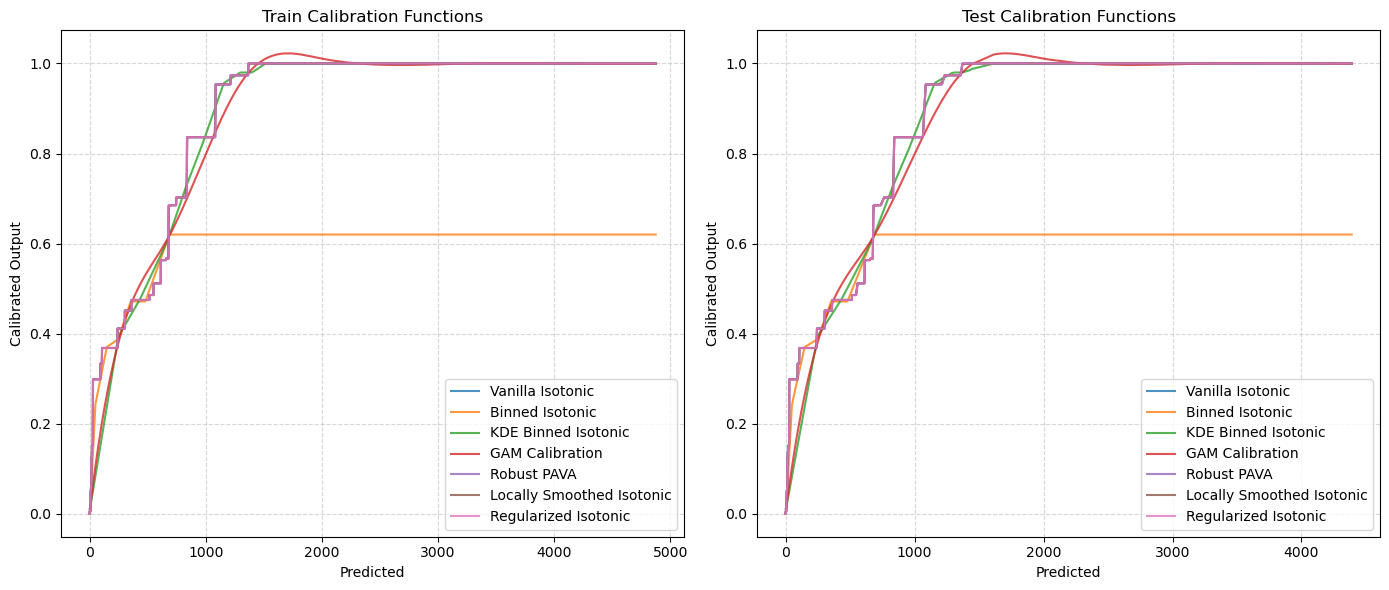

In [38]:
def plot_separate_calibration_functions(train_pred, train_actual, test_pred, test_actual, calibrated_train, calibrated_test):
    """
    Plots calibration functions separately for train and test data.

    Parameters:
    - train_pred, train_actual: Training set predictions and actual values
    - test_pred, test_actual: Test set predictions and actual values
    - calibrated_train, calibrated_test: Dictionary of calibration method outputs for train and test sets
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    def plot_calibration(ax, preds, actuals, calibrated_dict, title):
        """Helper function to plot separate calibration functions."""
        for name, calibrated_preds in calibrated_dict.items():
            if name.lower() == "raw":  # Exclude 'Raw' from being plotted
                continue
            
            sorted_idx = np.argsort(preds)
            ax.plot(preds[sorted_idx], calibrated_preds[sorted_idx], label=name, alpha=0.8)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("Calibrated Output")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

    # Plot Train
    plot_calibration(axes[0], train_pred, train_actual, calibrated_train, "Train Calibration Functions")

    # Plot Test
    plot_calibration(axes[1], test_pred, test_actual, calibrated_test, "Test Calibration Functions")

    plt.tight_layout()
    plt.show()

plot_separate_calibration_functions(train_pred, train_actual, test_pred, test_actual, calibrated_train, calibrated_test)

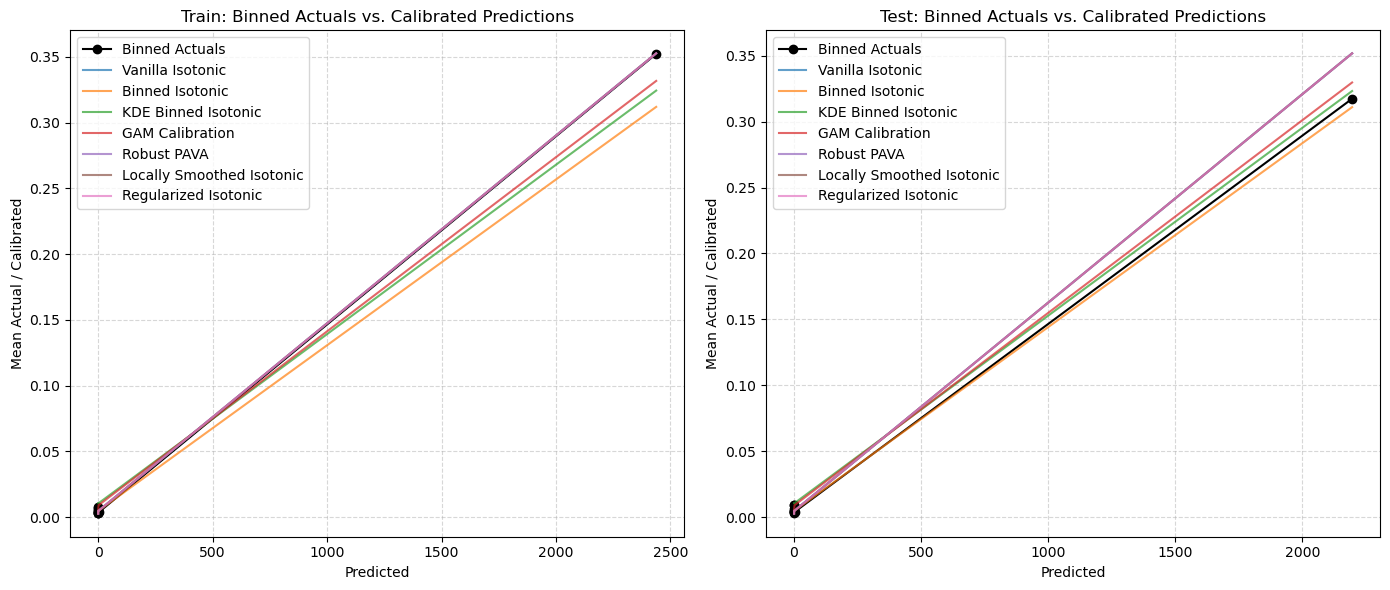

In [37]:
def plot_binned_vs_calibrated(train_pred, train_actual, test_pred, test_actual, calibrated_train, calibrated_test, n_bins=20):
    """
    Plots binned actuals vs. calibrated predictions from different calibration techniques for train and test sets.
    
    Parameters:
    - train_pred, train_actual: Training set predictions and actual values
    - test_pred, test_actual: Test set predictions and actual values
    - calibrated_train, calibrated_test: Dictionary of calibration method outputs for train and test sets
    - n_bins: Number of bins for grouping actuals and predictions
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    def plot_binned(ax, preds, actuals, calibrated_dict, title):
        """Helper function to plot binned actual vs. calibrated predictions."""
        bin_edges = np.percentile(preds, np.linspace(0, 100, n_bins + 1))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        binned_actuals = [
            np.mean(actuals[(preds >= bin_edges[i]) & (preds < bin_edges[i+1])]) 
            if np.any((preds >= bin_edges[i]) & (preds < bin_edges[i+1])) else np.nan
            for i in range(n_bins)
        ]
        
        ax.plot(bin_centers, binned_actuals, 'o-', label="Binned Actuals", color="black", markersize=6)

        for name, calibrated_preds in calibrated_dict.items():
            if name.lower() == "raw":  # Exclude 'Raw' from being plotted
                continue
            
            binned_calibrated = [
                np.mean(calibrated_preds[(preds >= bin_edges[i]) & (preds < bin_edges[i+1])]) 
                if np.any((preds >= bin_edges[i]) & (preds < bin_edges[i+1])) else np.nan
                for i in range(n_bins)
            ]
            ax.plot(bin_centers, binned_calibrated, label=name, alpha=0.7)
        
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Mean Actual / Calibrated")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

    # Plot Train
    plot_binned(axes[0], train_pred, train_actual, calibrated_train, "Train: Binned Actuals vs. Calibrated Predictions")

    # Plot Test
    plot_binned(axes[1], test_pred, test_actual, calibrated_test, "Test: Binned Actuals vs. Calibrated Predictions")

    plt.tight_layout()
    plt.show()

# Call the function
plot_binned_vs_calibrated(train_pred, train_actual, test_pred, test_actual, calibrated_train, calibrated_test, n_bins=10)

### Proof that Robust PAVA works?

In [39]:
np.random.seed(42)
n = 10000

train_preds = np.sort(np.abs(np.random.normal(50, 20, size=n)))
train_actuals = train_preds * 0.8 + np.random.normal(0, 5, size=n)
    
vanilla_iso = IsotonicRegression(out_of_bounds='clip')
vanilla_iso.fit(train_preds, train_actuals)
vanilla_calibrated = vanilla_iso.predict(train_preds)
    
robust_pava = RobustPAVACalibrator(minor_pctile=10).fit(train_actuals, train_preds)
robust_calibrated = robust_pava.predict(train_preds)
    
print("Vanilla Isotonic, mean calibrated:", np.mean(vanilla_calibrated))
print("Robust PAVA, mean calibrated:", np.mean(robust_calibrated))
    
for i in range(0, n, n//5):
    print(f"x: {train_preds[i]:.2f}  Vanilla y: {vanilla_calibrated[i]:.2f}  RobustPAVA y: {robust_calibrated[i]:.2f}")

Vanilla Isotonic, mean calibrated: 40.10556038334597
Robust PAVA, mean calibrated: 40.04487125096599
x: 0.01  Vanilla y: -3.38  RobustPAVA y: -3.38
x: 33.11  Vanilla y: 26.59  RobustPAVA y: 26.30
x: 44.95  Vanilla y: 36.04  RobustPAVA y: 35.85
x: 55.00  Vanilla y: 44.43  RobustPAVA y: 44.51
x: 66.79  Vanilla y: 53.72  RobustPAVA y: 53.72


### Independent Validation of Some of the Points

Optimal parameters from CV:
{'natural_spline_df': 10, 'reg_isotonic_alpha': 0.9, 'savitzky_golay_window': 11, 'savitzky_golay_polyorder': 4}


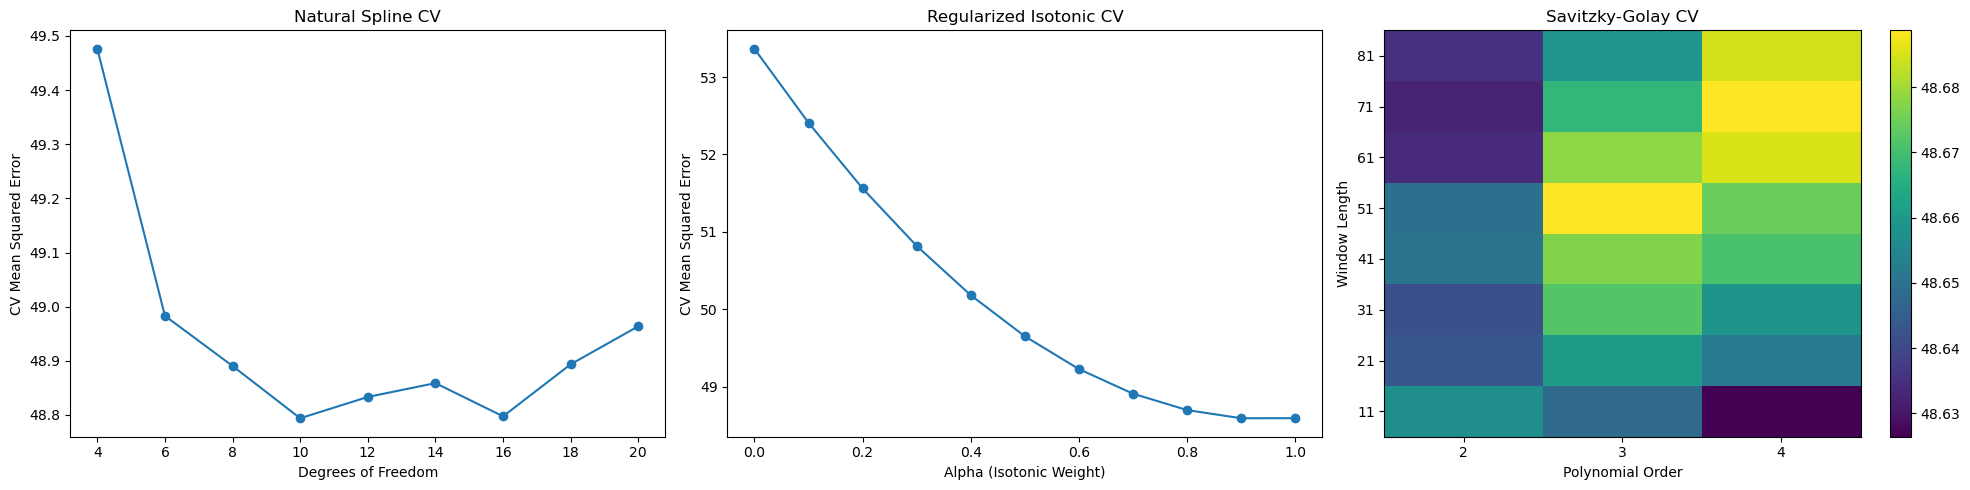

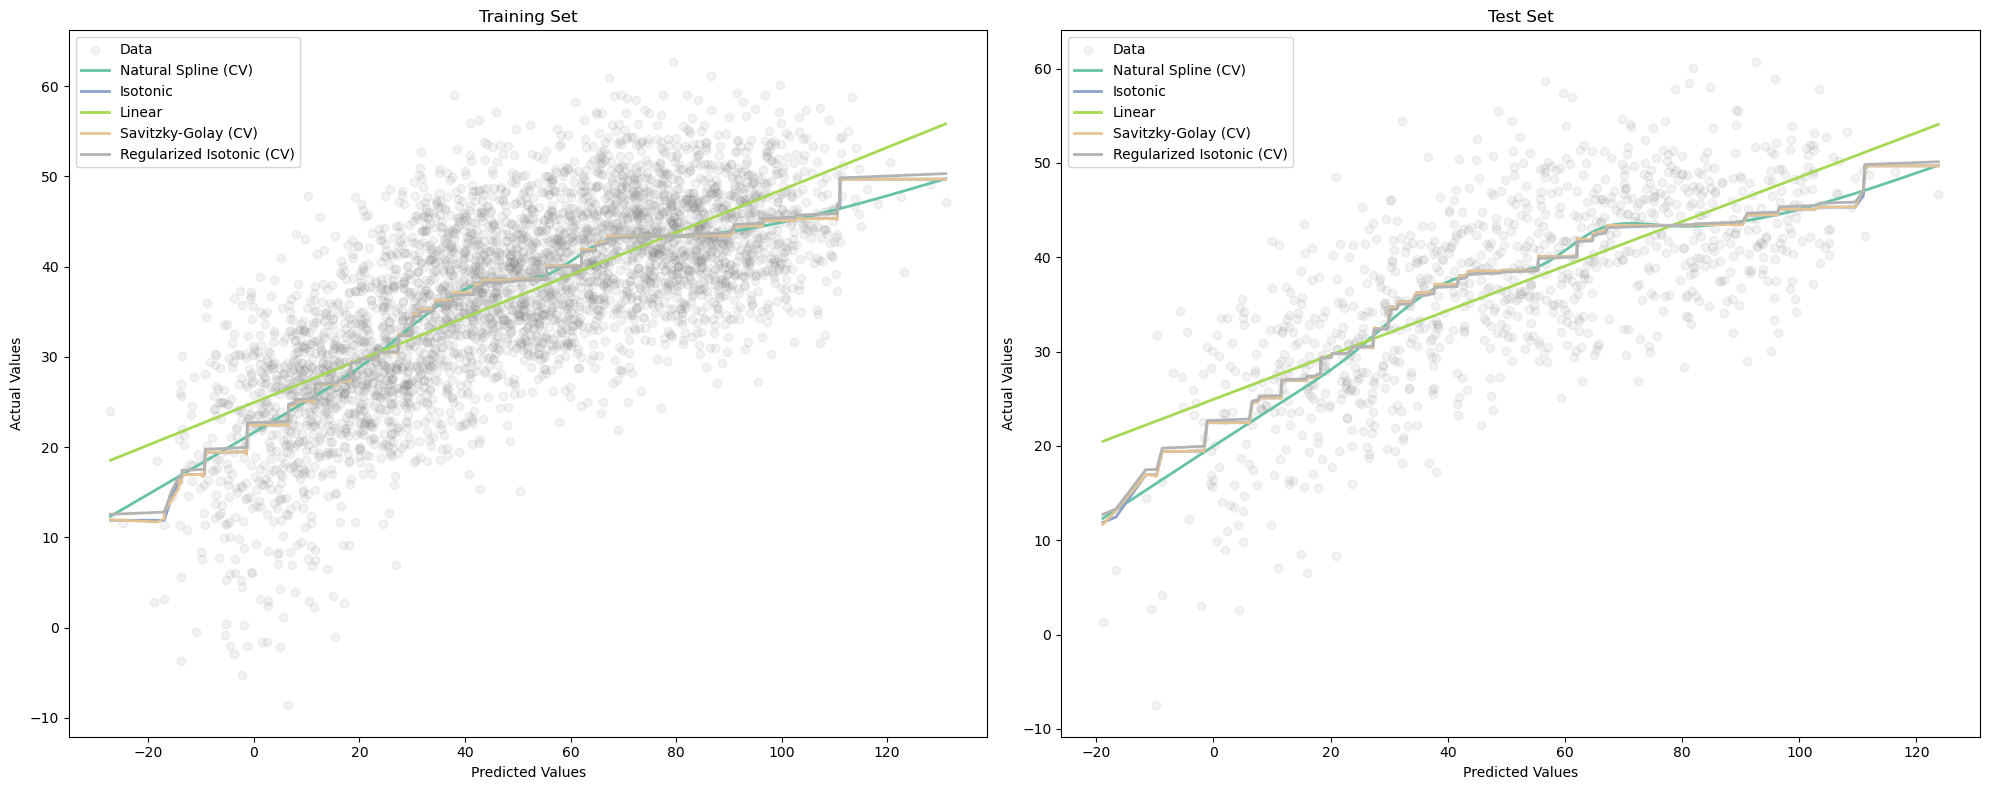


Final Metrics:
                      Method  Train MSE  Test MSE  Train MAE  Test MAE
0        Natural Spline (CV)    48.1643   47.7058     5.4735    5.5247
1                   Isotonic    47.1988   47.2967     5.4177    5.4942
2                     Linear    53.2619   51.3245     5.7334    5.7052
3        Savitzky-Golay (CV)    47.2808   47.2775     5.4236    5.4927
4  Regularized Isotonic (CV)    47.3273   47.2492     5.4219    5.4962


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import savgol_filter
from patsy import dmatrix
import statsmodels.api as sm
from typing import Tuple, Dict

class CalibrationComparison:
    def __init__(self, n_samples=5000, random_seed=42):
        self.n_samples = n_samples
        np.random.seed(random_seed)
        self.methods = {}
        
    def generate_data(self):
        """Generate synthetic data with a nonlinear but smooth underlying function."""
        X_true = np.linspace(0, 100, self.n_samples)
        y_true = np.log1p(X_true) * 10 + np.sin(X_true / 5) * 5
        
        # Add noise to predictions and actuals
        self.preds = X_true + np.random.normal(0, 10, size=self.n_samples)
        self.actuals = y_true + np.random.normal(0, 5, size=self.n_samples)
        
        # Train/Test Split (80/20)
        train_size = int(0.8 * self.n_samples)
        indices = np.random.permutation(self.n_samples)
        train_idx, test_idx = indices[:train_size], indices[train_size:]
        
        self.train_preds = self.preds[train_idx]
        self.test_preds = self.preds[test_idx]
        self.train_actuals = self.actuals[train_idx]
        self.test_actuals = self.actuals[test_idx]
    
    def _fit_natural_spline(self, x_train: np.ndarray, y_train: np.ndarray, 
                           x_test: np.ndarray, df: int) -> Tuple[np.ndarray, np.ndarray]:
        """Fit natural cubic spline with given degrees of freedom."""
        basis_train = dmatrix(f"cr(x, df={df})", {"x": x_train}, return_type='dataframe')
        basis_test = dmatrix(f"cr(x, df={df})", {"x": x_test}, return_type='dataframe')
        
        model = sm.OLS(y_train, basis_train).fit()
        return model.predict(basis_train), model.predict(basis_test)

    def _fit_savitzky_golay(self, x_train: np.ndarray, y_train: np.ndarray,
                             x_test: np.ndarray, window_length: int, polyorder: int) -> Tuple[np.ndarray, np.ndarray]:
        """Fit Savitzky-Golay filter with given parameters."""
        # First fit isotonic to get monotonic prediction
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(x_train, y_train)
        iso_train = iso.predict(x_train)
        iso_test = iso.predict(x_test)
        
        # Sort for interpolation
        train_sort_idx = np.argsort(x_train)
        test_sort_idx = np.argsort(x_test)
        
        # Apply Savitzky-Golay filter
        smoothed_train = savgol_filter(iso_train[train_sort_idx], window_length, polyorder)
        
        # Return to original order and interpolate for test
        train_pred = np.zeros_like(iso_train)
        train_pred[train_sort_idx] = smoothed_train
        test_pred = np.interp(x_test, x_train[train_sort_idx], smoothed_train)
        
        return train_pred, test_pred

    def _fit_regularized_isotonic(self, x_train: np.ndarray, y_train: np.ndarray,
                                x_test: np.ndarray, alpha: float) -> Tuple[np.ndarray, np.ndarray]:
        """Fit regularized isotonic regression with given alpha."""
        iso = IsotonicRegression(out_of_bounds="clip")
        lin = LinearRegression()
        
        iso.fit(x_train, y_train)
        lin.fit(x_train.reshape(-1, 1), y_train)
        
        iso_train = iso.predict(x_train)
        iso_test = iso.predict(x_test)
        lin_train = lin.predict(x_train.reshape(-1, 1))
        lin_test = lin.predict(x_test.reshape(-1, 1))
        
        return (alpha * iso_train + (1 - alpha) * lin_train,
                alpha * iso_test + (1 - alpha) * lin_test)

    def cv_tune_parameters(self, n_folds=5) -> Dict:
        """Cross-validate to find optimal parameters for each method."""
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        # Parameter grids
        df_values = np.arange(4, 21, 2)  # degrees of freedom for natural splines
        alpha_values = np.linspace(0, 1, 11)  # mixing parameter for regularized isotonic
        # Savitzky-Golay parameters
        window_values = np.array([11, 21, 31, 41, 51, 61, 71, 81])  # must be odd
        polyorder_values = np.array([2, 3, 4])  # polynomial order
        
        # Store CV results
        cv_results = {
            'natural_spline': {'params': df_values, 'scores': []},
            'reg_isotonic': {'params': alpha_values, 'scores': []},
            'savitzky_golay': {'params': [], 'scores': []}
        }
        
        # Cross-validate natural splines
        for df in df_values:
            fold_scores = []
            for train_idx, val_idx in kf.split(self.train_preds):
                x_train_cv = self.train_preds[train_idx]
                y_train_cv = self.train_actuals[train_idx]
                x_val_cv = self.train_preds[val_idx]
                y_val_cv = self.train_actuals[val_idx]
                
                _, val_pred = self._fit_natural_spline(x_train_cv, y_train_cv, x_val_cv, df)
                score = mean_squared_error(y_val_cv, val_pred)
                fold_scores.append(score)
            cv_results['natural_spline']['scores'].append(np.mean(fold_scores))
        
        # Cross-validate regularized isotonic
        for alpha in alpha_values:
            fold_scores = []
            for train_idx, val_idx in kf.split(self.train_preds):
                x_train_cv = self.train_preds[train_idx]
                y_train_cv = self.train_actuals[train_idx]
                x_val_cv = self.train_preds[val_idx]
                y_val_cv = self.train_actuals[val_idx]
                
                _, val_pred = self._fit_regularized_isotonic(x_train_cv, y_train_cv, x_val_cv, alpha)
                score = mean_squared_error(y_val_cv, val_pred)
                fold_scores.append(score)
            cv_results['reg_isotonic']['scores'].append(np.mean(fold_scores))
            
        # Cross-validate Savitzky-Golay
        best_sg_score = float('inf')
        best_sg_params = None
        
        for window in window_values:
            for polyorder in polyorder_values:
                if polyorder >= window:
                    continue  # Skip invalid combinations
                    
                fold_scores = []
                for train_idx, val_idx in kf.split(self.train_preds):
                    x_train_cv = self.train_preds[train_idx]
                    y_train_cv = self.train_actuals[train_idx]
                    x_val_cv = self.train_preds[val_idx]
                    y_val_cv = self.train_actuals[val_idx]
                    
                    _, val_pred = self._fit_savitzky_golay(x_train_cv, y_train_cv, x_val_cv, 
                                                         window, polyorder)
                    score = mean_squared_error(y_val_cv, val_pred)
                    fold_scores.append(score)
                
                mean_score = np.mean(fold_scores)
                cv_results['savitzky_golay']['params'].append((window, polyorder))
                cv_results['savitzky_golay']['scores'].append(mean_score)
                
                if mean_score < best_sg_score:
                    best_sg_score = mean_score
                    best_sg_params = (window, polyorder)
        
        # Find optimal parameters
        best_df_idx = np.argmin(cv_results['natural_spline']['scores'])
        best_alpha_idx = np.argmin(cv_results['reg_isotonic']['scores'])
        
        optimal_params = {
            'natural_spline_df': df_values[best_df_idx],
            'reg_isotonic_alpha': alpha_values[best_alpha_idx],
            'savitzky_golay_window': best_sg_params[0],
            'savitzky_golay_polyorder': best_sg_params[1]
        }
        
        # Store CV curves for plotting
        self.cv_results = cv_results
        
        return optimal_params
    
    def fit_all_methods(self):
        """Fit all calibration methods with cross-validated parameters."""
        # Get optimal parameters
        optimal_params = self.cv_tune_parameters()
        print(f"Optimal parameters from CV:\n{optimal_params}")
        
        # 1. Natural Spline with optimal df
        self.methods["Natural Spline (CV)"] = self._fit_natural_spline(
            self.train_preds, 
            self.train_actuals,
            self.test_preds,
            optimal_params['natural_spline_df']
        )
        
        # 2. Vanilla Isotonic
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(self.train_preds, self.train_actuals)
        self.methods["Isotonic"] = (
            iso.predict(self.train_preds),
            iso.predict(self.test_preds)
        )
        
        # 3. Linear baseline
        lin_reg = LinearRegression()
        lin_reg.fit(self.train_preds.reshape(-1, 1), self.train_actuals)
        self.methods["Linear"] = (
            lin_reg.predict(self.train_preds.reshape(-1, 1)),
            lin_reg.predict(self.test_preds.reshape(-1, 1))
        )
        
        # 4. Savitzky-Golay with optimal parameters
        self.methods["Savitzky-Golay (CV)"] = self._fit_savitzky_golay(
            self.train_preds,
            self.train_actuals,
            self.test_preds,
            optimal_params['savitzky_golay_window'],
            optimal_params['savitzky_golay_polyorder']
        )
        
        # 5. Regularized Isotonic with optimal alpha
        self.methods["Regularized Isotonic (CV)"] = self._fit_regularized_isotonic(
            self.train_preds,
            self.train_actuals,
            self.test_preds,
            optimal_params['reg_isotonic_alpha']
        )

    def compute_metrics(self):
        """Compute comprehensive metrics for all methods."""
        results = []
        for name, (train_pred, test_pred) in self.methods.items():
            metrics = {
                'Method': name,
                'Train MSE': mean_squared_error(self.train_actuals, train_pred),
                'Test MSE': mean_squared_error(self.test_actuals, test_pred),
                'Train MAE': mean_absolute_error(self.train_actuals, train_pred),
                'Test MAE': mean_absolute_error(self.test_actuals, test_pred),
            }
            results.append(metrics)
        return pd.DataFrame(results)
    
    def plot_cv_curves(self):
        """Plot cross-validation curves."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        
        # Natural spline CV curve
        df_values = self.cv_results['natural_spline']['params']
        df_scores = self.cv_results['natural_spline']['scores']
        ax1.plot(df_values, df_scores, 'o-')
        ax1.set_xlabel('Degrees of Freedom')
        ax1.set_ylabel('CV Mean Squared Error')
        ax1.set_title('Natural Spline CV')
        
        # Regularized isotonic CV curve
        alpha_values = self.cv_results['reg_isotonic']['params']
        alpha_scores = self.cv_results['reg_isotonic']['scores']
        ax2.plot(alpha_values, alpha_scores, 'o-')
        ax2.set_xlabel('Alpha (Isotonic Weight)')
        ax2.set_ylabel('CV Mean Squared Error')
        ax2.set_title('Regularized Isotonic CV')
        
        # Savitzky-Golay CV surface
        window_lengths = sorted(list(set([p[0] for p in self.cv_results['savitzky_golay']['params']])))
        polyorders = sorted(list(set([p[1] for p in self.cv_results['savitzky_golay']['params']])))
        
        scores_matrix = np.full((len(window_lengths), len(polyorders)), np.nan)
        for (window, polyorder), score in zip(self.cv_results['savitzky_golay']['params'],
                                            self.cv_results['savitzky_golay']['scores']):
            i = window_lengths.index(window)
            j = polyorders.index(polyorder)
            scores_matrix[i, j] = score
        
        im = ax3.imshow(scores_matrix, aspect='auto', origin='lower')
        plt.colorbar(im, ax=ax3)
        ax3.set_xticks(range(len(polyorders)))
        ax3.set_yticks(range(len(window_lengths)))
        ax3.set_xticklabels(polyorders)
        ax3.set_yticklabels(window_lengths)
        ax3.set_xlabel('Polynomial Order')
        ax3.set_ylabel('Window Length')
        ax3.set_title('Savitzky-Golay CV')
        
        plt.tight_layout()
        plt.show()
        
    def plot_comparison(self):
        """Plot comparison of all methods."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Training set
        sort_idx = np.argsort(self.train_preds)
        ax1.scatter(self.train_preds, self.train_actuals, 
                   alpha=0.1, color='gray', label='Data')
        
        # Test set
        test_sort_idx = np.argsort(self.test_preds)
        ax2.scatter(self.test_preds, self.test_actuals,
                   alpha=0.1, color='gray', label='Data')
        
        # Plot each method
        colors = plt.cm.Set2(np.linspace(0, 1, len(self.methods)))
        for (name, (train_pred, test_pred)), color in zip(self.methods.items(), colors):
            ax1.plot(self.train_preds[sort_idx], train_pred[sort_idx],
                    label=name, color=color, linewidth=2)
            ax2.plot(self.test_preds[test_sort_idx], test_pred[test_sort_idx],
                    label=name, color=color, linewidth=2)
        
        ax1.set_title('Training Set')
        ax1.set_xlabel('Predicted Values')
        ax1.set_ylabel('Actual Values')
        ax1.legend()
        
        ax2.set_title('Test Set')
        ax2.set_xlabel('Predicted Values')
        ax2.set_ylabel('Actual Values')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize and run comparison
    comparison = CalibrationComparison(n_samples=5000)
    comparison.generate_data()
    comparison.fit_all_methods()
    
    # Plot CV curves
    comparison.plot_cv_curves()
    
    # Plot final comparison
    comparison.plot_comparison()
    
    # Display metrics
    metrics_df = comparison.compute_metrics()
    print("\nFinal Metrics:")
    print(metrics_df.round(4))